# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [ ]:
np.log

In [9]:
np.log(0.1)

-2.3025850929940455

In [64]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive,softmax_loss_vectorized
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.404056
sanity check: 2.302585


In [69]:
softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

(2.40405554917305,
 array([[ 0.45021169,  2.02634822, -0.05379599, ...,  0.58012168,
         -0.84563525, -0.21066034],
        [ 0.47330062,  2.24241182,  0.00979442, ...,  0.67085478,
         -0.91045978, -0.2346975 ],
        [ 0.51065891,  2.65254305,  0.23360919, ...,  0.92569541,
         -0.89697214, -0.2863673 ],
        ...,
        [-0.56280294,  2.03218711, -0.79713653, ...,  0.16161168,
         -0.91994359,  0.00860295],
        [-0.77013405,  2.17079722, -0.75594689, ...,  0.18787498,
         -0.98800186, -0.10694555],
        [ 0.10155939,  0.10684041,  0.09890561, ...,  0.09719402,
          0.10000282,  0.09660169]]))

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** If we get W=0, then loss will be log(C). As we pick W near 0, then we expect Loss near -log(0.1)


In [70]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.465403 analytic: -1.465403, relative error: 2.019026e-08
numerical: 3.274089 analytic: 3.274089, relative error: 1.133083e-08
numerical: 2.217558 analytic: 2.217558, relative error: 1.709565e-08
numerical: 0.307193 analytic: 0.307193, relative error: 2.625354e-07
numerical: -0.576130 analytic: -0.576130, relative error: 7.461680e-08
numerical: 2.034367 analytic: 2.034367, relative error: 1.421226e-08
numerical: -1.171574 analytic: -1.171574, relative error: 1.566217e-09
numerical: -0.811486 analytic: -0.811486, relative error: 1.007816e-09
numerical: -0.434491 analytic: -0.434491, relative error: 5.473159e-08
numerical: -1.671987 analytic: -1.671987, relative error: 1.176535e-08
numerical: 5.403104 analytic: 5.403104, relative error: 1.383314e-08
numerical: 2.169558 analytic: 2.169558, relative error: 2.870417e-08
numerical: 1.811801 analytic: 1.811801, relative error: 2.952663e-08
numerical: -2.936232 analytic: -2.936232, relative error: 1.215141e-08
numerical: -3.749548

In [75]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.404056e+00 computed in 0.264211s
vectorized loss: 2.404056e+00 computed in 0.006711s
Loss difference: 0.000000
Gradient difference: 0.000000


In [98]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
from itertools import product
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(2.7822222222222226e-06, 5e-6,10)
regularization_strengths = np.linspace(1.5e3, 5e4,10)
for l,r in product(learning_rates,regularization_strengths):
    soft = Softmax()
    soft.train(X_train,y_train,learning_rate=l,reg=r,num_iters=300)
    validation_accuracy = np.mean(y_val == soft.predict(X_val))
    training_accuracy = np.mean(y_train == soft.predict(X_train))
    results[(l,r)] = (training_accuracy,validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_softmax = soft
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.782222e-06 reg 1.500000e+03 train accuracy: 0.370102 val accuracy: 0.375000
lr 2.782222e-06 reg 6.888889e+03 train accuracy: 0.348959 val accuracy: 0.365000
lr 2.782222e-06 reg 1.227778e+04 train accuracy: 0.323980 val accuracy: 0.333000
lr 2.782222e-06 reg 1.766667e+04 train accuracy: 0.309612 val accuracy: 0.325000
lr 2.782222e-06 reg 2.305556e+04 train accuracy: 0.288469 val accuracy: 0.288000
lr 2.782222e-06 reg 2.844444e+04 train accuracy: 0.263041 val accuracy: 0.291000
lr 2.782222e-06 reg 3.383333e+04 train accuracy: 0.295306 val accuracy: 0.308000
lr 2.782222e-06 reg 3.922222e+04 train accuracy: 0.287653 val accuracy: 0.306000
lr 2.782222e-06 reg 4.461111e+04 train accuracy: 0.300776 val accuracy: 0.300000
lr 2.782222e-06 reg 5.000000e+04 train accuracy: 0.264449 val accuracy: 0.285000
lr 3.028642e-06 reg 1.500000e+03 train accuracy: 0.382245 val accuracy: 0.373000
lr 3.028642e-06 reg 6.888889e+03 train accuracy: 0.351429 val accuracy: 0.341000
lr 3.028642e-06 reg 1.227778

In [99]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:True

*Your explanation*: For SVM if we chose W=0 and delta = 0, any additional point will not change loss. For Softmax if we want to save loss as it was we need to pick datapoint which give us infinite number score for target class and -infinite for all other.

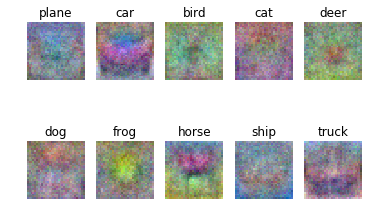

In [100]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])